In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/bki2w/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [3]:
T = Float32

Float32

In [4]:
#### USING SAME DATA AS DCAlign-master

### PF00684 data ##
open("/home/louise/MSA/Data/test/PF00684/")
q = 21; L = 67; 
ctype=Symbol("amino")
typel=Symbol("bm")

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

### PF00684 sequences ##

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [5]:
open("/home/louise/MSA/Data/test/PF00397/")
q = 21; L = 31; 
ctype=Symbol("amino")
typel=Symbol("bm")

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [6]:
muext = 0.00;
muint = 2.50;

In [7]:
println("Consider this sequence: ")
# consider one random sequence as an example
idx0 = 20# rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = BpAlignGpu.Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by HMMer (without and with insertions): ")
println(seqsol)
println(seqins)

Consider this sequence: 
A0A401GBT9_9APHY/8-47
Full length: 
MAPPPLPLGWTEHMSPTGQPYYFNTQTQESTYVRPLPPFP
Aligned by HMMer (without and with insertions): 
LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP
LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP


In [13]:
q, N, L

(21, 40, 31)

In [9]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=40 q=21 size=1.619 MiB]

In [10]:
damp=T(0.01)
tol=T(1e-5)
tolnorm=T(1e-10)
tmax=10
initcond=:unif # :random or :unif
upscheme=:random # :random or :unif
lr=:sce  # :sce or :mf or :sr
beta=T(0.4)
verbose=true
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose)

ParamAlgo{Float32}
-------------
damp=0.01
tol=1.0e-5
tolnorm=1.0e-10
tmax=10
upscheme=random
initcond=unif
lr=sce
beta=0.4
verbose=true
-------------

In [11]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

# One run

In [14]:
pa.beta = 0.7
pa.damp = 0.75
pa.tol = 1e-3
@show pa.beta, pa.damp, pa.tol
@time BpAlignGpu.test_sweep!(1,af,pm,pa)

(pa.beta, pa.damp, pa.tol) = (0.7f0, 0.75f0, 0.001f0)
t=1	 err=0.061188057
  0.122753 seconds (114.18 k allocations: 6.189 MiB, 51.20% compilation time)


In [15]:
@time BpAlignGpu.test_sweep!(1000,af,pm,pa)

t=1	 err=0.049403414
t=2	 err=0.04139173
t=3	 err=0.03568667
t=4	 err=0.031432062
t=5	 err=0.028103292
t=6	 err=0.025364518
t=7	 err=0.02296269
t=8	 err=0.020602733
t=9	 err=0.024046756
t=10	 err=0.034365408
t=11	 err=0.06516709
t=12	 err=0.11946052
t=13	 err=0.13923112
t=14	 err=0.1707933
t=15	 err=0.12849182
t=16	 err=0.10619724
t=17	 err=0.104074955
t=18	 err=0.10564667
t=19	 err=0.102873296
t=20	 err=0.11028692
t=21	 err=0.12619057
t=22	 err=0.10340078
t=23	 err=0.12391436
t=24	 err=0.2414751
t=25	 err=0.23297918
t=26	 err=0.5129494
t=27	 err=0.83460605
t=28	 err=0.83732766
t=29	 err=0.7847294
t=30	 err=0.7914457
t=31	 err=0.6414312
t=32	 err=0.5867265
t=33	 err=0.5809471
t=34	 err=0.44532135
t=35	 err=0.43241635
t=36	 err=0.48889446
t=37	 err=0.52131677
t=38	 err=0.53356516
t=39	 err=0.664667
t=40	 err=0.64754915
t=41	 err=0.7750267
t=42	 err=0.812541
t=43	 err=0.84758705
t=44	 err=0.8578804
t=45	 err=0.8201949
t=46	 err=0.8509103
t=47	 err=0.7878938
t=48	 err=0.806268
t=49	 err=0

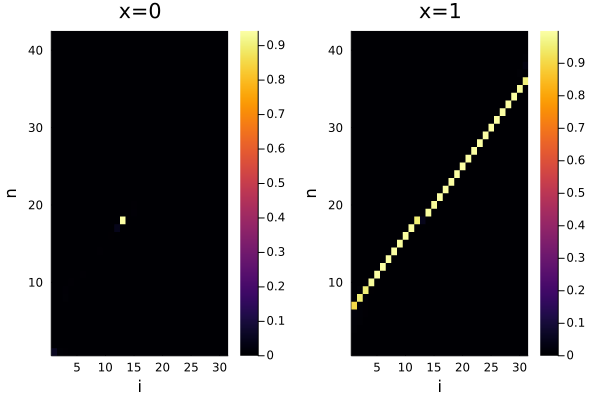

In [16]:
using Plots
bel=Array(af.bpb.beliefs);
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1)

In [17]:
#findall(isinf.(af.bpb.beliefs)), findall(isnan.(af.bpb.beliefs))
#findall(isinf.(af.bpb.joint_chain)), findall(isnan.(af.bpb.joint_chain))

In [18]:
xnsol, maxbel = BpAlignGpu.solmaxbel(af)
seqpa, seqpo, deb, fin = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)

("LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP", "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP", 6, 35)

In [19]:
seqpa == "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP", seqpo == "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP"

(true, true)

In [20]:
BpAlignGpu.compute_cost_function(pm.J, pm.H, seqpo, L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

(onesite, couplings) = (-4.881430014967918, -53.71831221552566)
(gapcost, inscost) = (2.5f0, 0.0)


-56.099743f0

In [21]:
check = BpAlignGpu.check_sr!(xnsol, L, N)
finderrors, errL = findall(x->x==1, check), check[L]

(Int64[], 0)

In [22]:
for i in finderrors
    @show i
    println(xnsol[i-1], ", ", xnsol[i])
end

In [23]:
logzi = BpAlignGpu.logZi(af, pm, pa)/L
logZa  = BpAlignGpu.logZa(af, pm, pa)/L
logZia = BpAlignGpu.logZia(af, pm)/L
lr_free = BpAlignGpu.lr_freeen(af, pm)/L
free_nrj = -logzi - logZa + logZia - lr_free
logzi, logZa, logZia, lr_free, free_nrj

(-11.145244f0, 6.803842f0, -5.6157494f0, 1.5497721182933497, -2.8241199004283595)

# Tolerance for convergence

In [101]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

In [102]:
# TOL STUDY
pa.beta = 0.8
pa.damp = 0.75

tols = [1e-3, 1e-4, 1e-5, 1e-6]
bels_tols = fill(zeros(N+2,2,L), eachindex(tols))
diff_tols = fill(zeros(N+2,2,L), eachindex(tols))
errs_tols = fill(0.0, eachindex(tols))
sol_tols = fill(("", "", 0, 0), eachindex(tols))
@show length(tols)
for (i,tol) in pairs(tols)
    pa.tol = tol
    @show tol
    
    BpAlignGpu.test_sweep!(1000,af,pm,pa)
    
    bels_tols[i] = Array(af.bpb.beliefs)
    diff_tols[i] = Array(abs.(af.bpb.beliefs_old .- af.bpb.beliefs))
    errs_tols[i] = maximum(diff_tols[i])
    
    xnsol, maxbel = BpAlignGpu.solmaxbel(af)
    sol_tols[i] = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)
end

length(tols) = 4
tol = 0.001
t=1	 err=0.08814856
t=2	 err=0.06303416
t=3	 err=0.051222384
t=4	 err=0.043008745
t=5	 err=0.037056744
t=6	 err=0.03254941
t=7	 err=0.02893284
t=8	 err=0.02569604
t=9	 err=0.035860483
t=10	 err=0.044662017
t=11	 err=0.07794209
t=12	 err=0.19884476
t=13	 err=0.12770535
t=14	 err=0.20939642
t=15	 err=0.13876325
t=16	 err=0.11476827
t=17	 err=0.123747885
t=18	 err=0.105722964
t=19	 err=0.09874731
t=20	 err=0.10780454
t=21	 err=0.11377987
t=22	 err=0.12488684
t=23	 err=0.14308196
t=24	 err=0.12550846
t=25	 err=0.14557159
t=26	 err=0.5953975
t=27	 err=0.8372015
t=28	 err=0.9678685
t=29	 err=0.968483
t=30	 err=0.89485687
t=31	 err=0.86642796
t=32	 err=0.6685864
t=33	 err=0.6851531
t=34	 err=0.7854624
t=35	 err=0.7841786
t=36	 err=0.559223
t=37	 err=0.55774176
t=38	 err=0.7397365
t=39	 err=0.7360438
t=40	 err=0.7398841
t=41	 err=0.7592106
t=42	 err=0.84680593
t=43	 err=0.8758824
t=44	 err=0.8924985
t=45	 err=0.8988944
t=46	 err=0.73629034
t=47	 err=0.7247636
t=48	

t=66	 err=0.045210302
t=67	 err=0.011704683
t=68	 err=0.011663675
t=69	 err=0.0046420693
t=70	 err=0.0046266913
t=71	 err=0.0024237037
t=72	 err=0.002477467
t=73	 err=0.00082588196
t=74	 err=0.0008817315
t=75	 err=0.00030750036
t=76	 err=0.0003412962
t=77	 err=0.000113443704
t=78	 err=0.00014966726
t=79	 err=0.00011700392
t=80	 err=0.00012862682
t=81	 err=0.00090157986
t=82	 err=0.0046017766
t=83	 err=0.019346952
t=84	 err=0.07788181
t=85	 err=0.075360894
t=86	 err=0.025214374
t=87	 err=0.028693914
t=88	 err=0.02902019
t=89	 err=0.011323214
t=90	 err=0.011428475
t=91	 err=0.004706025
t=92	 err=0.004670799
t=93	 err=0.0022592545
t=94	 err=0.002125144
t=95	 err=0.0012164116
t=96	 err=0.0010293722
t=97	 err=0.00071656704
t=98	 err=0.00055515766
t=99	 err=0.0004362464
t=100	 err=0.00033849478
t=101	 err=0.00034463406
t=102	 err=0.00030887127
t=103	 err=0.00028914213
t=104	 err=0.00026136637
t=105	 err=0.00022804737
t=106	 err=0.00021622037
t=107	 err=0.00021003521
t=108	 err=0.00028118872


t=43	 err=0.07281673
t=44	 err=0.029372633
t=45	 err=0.029375136
t=46	 err=0.0198192
t=47	 err=0.020185173
t=48	 err=0.008904815
t=49	 err=0.008454561
t=50	 err=0.0025662184
t=51	 err=0.016945139
t=52	 err=0.021710336
t=53	 err=0.30719084
t=54	 err=0.24037386
t=55	 err=0.4499445
t=56	 err=0.44994324
t=57	 err=0.84583783
t=58	 err=0.79222167
t=59	 err=0.2291119
t=60	 err=0.16559492
t=61	 err=0.032942876
t=62	 err=0.057201564
t=63	 err=0.01257772
t=64	 err=0.03496135
t=65	 err=0.0058044195
t=66	 err=0.008981466
t=67	 err=0.00339669
t=68	 err=0.0033416748
t=69	 err=0.0033457875
t=70	 err=0.0031666756
t=71	 err=0.0031818748
t=72	 err=0.001689434
t=73	 err=0.0017035604
t=74	 err=0.000715971
t=75	 err=0.0007169843
t=76	 err=0.00029951334
t=77	 err=0.00029200315
t=78	 err=0.00012296438
t=79	 err=0.00011432171
t=80	 err=0.00914681
t=81	 err=0.00856483
t=82	 err=0.0024228692
t=83	 err=0.0024793744
t=84	 err=0.0021883845
t=85	 err=0.0022210479
t=86	 err=0.005416155
t=87	 err=0.0054268837
t=88	 e

t=399	 err=8.416176e-5
t=400	 err=7.081032e-5
t=401	 err=0.00019675493
t=402	 err=0.20115893
t=403	 err=0.19722188
t=404	 err=0.08487779
t=405	 err=0.24689919
t=406	 err=0.24635267
t=407	 err=0.030151367
t=408	 err=0.09520131
t=409	 err=0.095680654
t=410	 err=0.24889767
t=411	 err=0.24864918
t=412	 err=0.24550575
t=413	 err=0.24514115
t=414	 err=0.10173637
t=415	 err=0.10184932
t=416	 err=0.024049342
t=417	 err=0.024386525
t=418	 err=0.0052801967
t=419	 err=0.005388379
t=420	 err=0.0016168766
t=421	 err=0.0013634562
t=422	 err=0.00057207234
t=423	 err=0.00049197674
t=424	 err=0.0003337264
t=425	 err=0.0002502203
t=426	 err=0.00015860796
t=427	 err=9.304285e-5
t=428	 err=9.047985e-5
t=429	 err=9.602308e-5
t=430	 err=0.004011154
t=431	 err=0.0040608644
t=432	 err=0.00312227
t=433	 err=0.0031761527
t=434	 err=0.0041851997
t=435	 err=0.004201412
t=436	 err=0.018243194
t=437	 err=0.060887307
t=438	 err=0.06673908
t=439	 err=0.06651831
t=440	 err=0.061931875
t=441	 err=0.8960678
t=442	 err=0

t=752	 err=0.002414167
t=753	 err=0.034017146
t=754	 err=0.032916307
t=755	 err=0.15845501
t=756	 err=0.15739256
t=757	 err=0.4476481
t=758	 err=0.4470471
t=759	 err=0.42337203
t=760	 err=0.4227029
t=761	 err=0.20734453
t=762	 err=0.20694065
t=763	 err=0.054389954
t=764	 err=0.054449618
t=765	 err=0.010974348
t=766	 err=0.011345565
t=767	 err=0.0061048865
t=768	 err=0.016098803
t=769	 err=0.89632785
t=770	 err=0.8740312
t=771	 err=0.55656064
t=772	 err=0.5648964
t=773	 err=0.14607936
t=774	 err=0.14554983
t=775	 err=0.027332544
t=776	 err=0.027356386
t=777	 err=0.0047447085
t=778	 err=0.004661083
t=779	 err=0.0073586106
t=780	 err=0.007180333
t=781	 err=0.056360364
t=782	 err=0.056111336
t=783	 err=0.036912918
t=784	 err=0.036575973
t=785	 err=0.05835855
t=786	 err=0.057684302
t=787	 err=0.049220204
t=788	 err=0.04942888
t=789	 err=0.018936157
t=790	 err=0.018877745
t=791	 err=0.0054068565
t=792	 err=0.0049835443
t=793	 err=0.0018048398
t=794	 err=0.1169613
t=795	 err=0.11724359
t=796	

In [103]:
errs_tols

4-element Vector{Float64}:
 0.0008970964699983597
 9.600073099136353e-5
 8.108094334602356e-6
 0.0038881301879882812

In [113]:
seqpa = "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP"
seqpo = "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP";
sol_tols[1][2] == seqpo, sol_tols[1][2] == sol_tols[2][2], sol_tols[2][2] == sol_tols[3][2], sol_tols[3][2] == sol_tols[4][2]

(true, true, true, true)

In [114]:
sol_tols[1][1] == seqpa, sol_tols[1][1] == sol_tols[2][1], sol_tols[2][1] == sol_tols[3][1], sol_tols[3][1] == sol_tols[4][1]

(true, true, true, true)

tols[i] = 1.0e-6


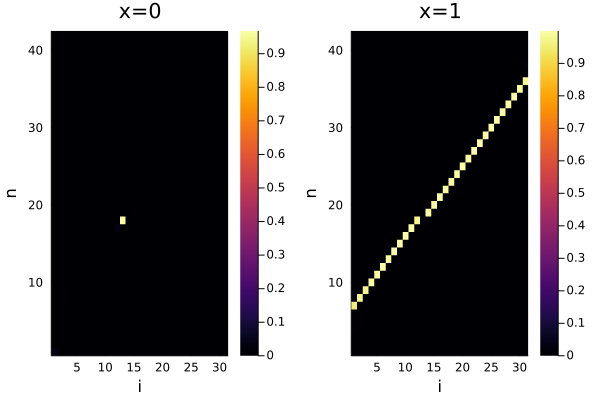

In [115]:
using Plots
i=4
@show tols[i]
bel = bels_tols[i];
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1)

### diff between last iterations

(tols[i], errs_tols[i]) = (1.0e-6, 0.0038881301879882812)


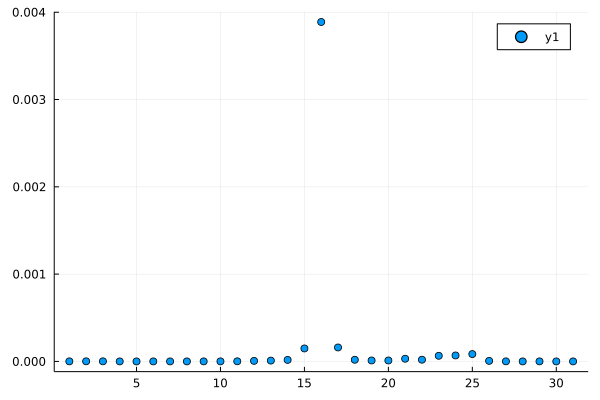

In [116]:
i=4
@show tols[i], errs_tols[i]
scatter(1:L, [maximum(diff_tols[i][:,:,j]) for j=1:L])

j = 16


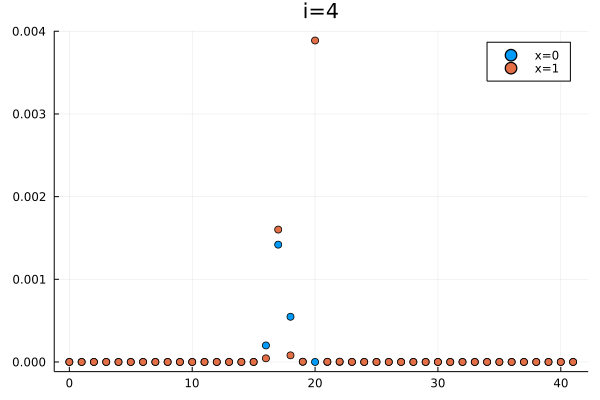

In [117]:
j=16
@show j
scatter(0:N+1, diff_tols[i][:,1,j], label="x=0", title="i=$i")
scatter!(0:N+1, diff_tols[i][:,2,j], label="x=1")

### diff between tolerances

In [118]:
i1 = 3; i2 = 4
maximum(abs.(bels_tols[i1] .- bels_tols[i2]))

0.00019407272338867188

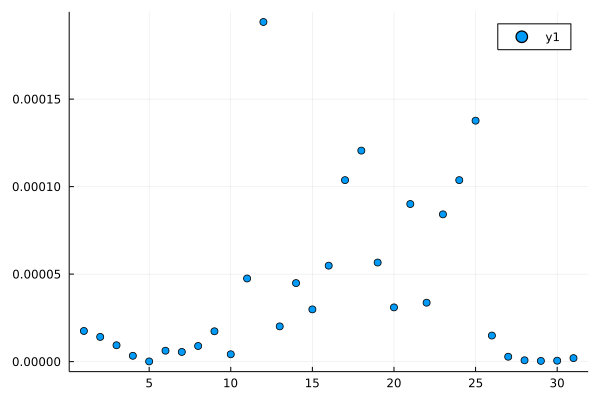

In [119]:
diftol = abs.(bels_tols[i1] .- bels_tols[i2])
scatter(1:L, [maximum(diftol[:,:,j]) for j=1:L])

j = 12


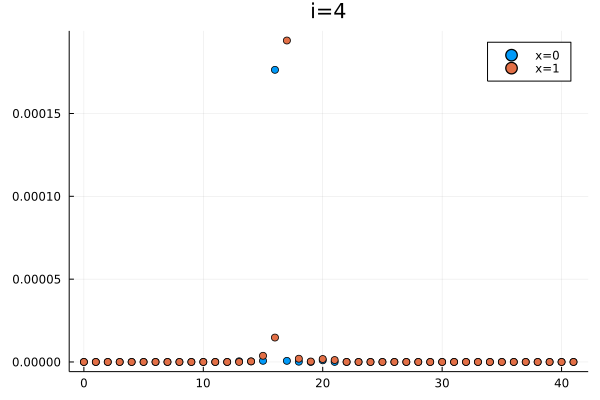

In [120]:
j=12
@show j
scatter(0:N+1, diftol[:,1,j], label="x=0", title="i=$i")
scatter!(0:N+1, diftol[:,2,j], label="x=1")

# Temperature

In [128]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

In [129]:
# TEMPERATURE STUDY
pa.tol = 1e-3
pa.damp = 0.75

betas = 0.6:0.05:1.0
bels_beta = fill(zeros(N+2,2,L), eachindex(betas))
diff_beta = fill(zeros(N+2,2,L), eachindex(betas))
errs_beta = fill(0.0, eachindex(betas))
sol_beta = fill(("", "", 0, 0), eachindex(betas))
@show length(betas)
for (i,beta) in pairs(betas)
    pa.beta = beta
    @show beta
    BpAlignGpu.test_sweep!(1000,af,pm,pa)

    bels_beta[i] = Array(af.bpb.beliefs)
    diff_beta[i] = Array(abs.(af.bpb.beliefs_old .- af.bpb.beliefs))
    errs_beta[i] = maximum(diff_beta[i])

    xnsol, maxbel = BpAlignGpu.solmaxbel(af)
    sol_beta[i] = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)
end

length(betas) = 9
beta = 0.6
t=1	 err=0.07289646
t=2	 err=0.058658846
t=3	 err=0.047036275
t=4	 err=0.039325982
t=5	 err=0.033931494
t=6	 err=0.02995649
t=7	 err=0.026875526
t=8	 err=0.024374694
t=9	 err=0.022260368
t=10	 err=0.020406693
t=11	 err=0.018721342
t=12	 err=0.017118335
t=13	 err=0.015485972
t=14	 err=0.013626188
t=15	 err=0.020140436
t=16	 err=0.032800104
t=17	 err=0.066505626
t=18	 err=0.11578027
t=19	 err=0.10681282
t=20	 err=0.14152963
t=21	 err=0.14612035
t=22	 err=0.067189574
t=23	 err=0.106244445
t=24	 err=0.12457162
t=25	 err=0.12241292
t=26	 err=0.100055635
t=27	 err=0.122003466
t=28	 err=0.0892472
t=29	 err=0.1011768
t=30	 err=0.08370307
t=31	 err=0.09053627
t=32	 err=0.08121699
t=33	 err=0.07507318
t=34	 err=0.06897628
t=35	 err=0.064077556
t=36	 err=0.055538177
t=37	 err=0.09139788
t=38	 err=0.61215705
t=39	 err=0.5420546
t=40	 err=0.7073623
t=41	 err=0.69934136
t=42	 err=0.5963921
t=43	 err=0.38228065
t=44	 err=0.344093
t=45	 err=0.3191933
t=46	 err=0.14362115
t

t=159	 err=0.8891754
t=160	 err=0.8833786
t=161	 err=0.95953953
t=162	 err=0.94135475
t=163	 err=0.97626156
t=164	 err=0.97619164
t=165	 err=0.96057063
t=166	 err=0.96193683
t=167	 err=0.9588828
t=168	 err=0.9534587
t=169	 err=0.89816713
t=170	 err=0.8976894
t=171	 err=0.802524
t=172	 err=0.8111825
t=173	 err=0.6229092
t=174	 err=0.6298846
t=175	 err=0.39053017
t=176	 err=0.3950647
t=177	 err=0.21146572
t=178	 err=0.21731377
t=179	 err=0.05654347
t=180	 err=0.060191035
t=181	 err=0.052334905
t=182	 err=0.020272732
t=183	 err=0.016969144
t=184	 err=0.007883155
t=185	 err=0.0050355066
t=186	 err=0.0050697923
t=187	 err=0.004205346
t=188	 err=0.004346788
t=189	 err=0.004704416
t=190	 err=0.0047935843
t=191	 err=0.16379088
t=192	 err=0.16418606
t=193	 err=0.5046313
t=194	 err=0.50493133
t=195	 err=0.9763664
t=196	 err=0.9760258
t=197	 err=0.9937822
t=198	 err=0.9925655
t=199	 err=0.9811319
t=200	 err=0.9634959
t=201	 err=0.96260333
t=202	 err=0.97856075
t=203	 err=0.97518986
t=204	 err=0.9

t=21	 err=0.5961276
t=22	 err=0.2749998
t=23	 err=0.40516004
t=24	 err=0.24375197
t=25	 err=0.37195456
t=26	 err=0.16657874
t=27	 err=0.27436653
t=28	 err=0.10537368
t=29	 err=0.17696911
t=30	 err=0.080891185
t=31	 err=0.8560285
t=32	 err=0.8558926
t=33	 err=0.99283004
t=34	 err=0.98304105
t=35	 err=0.99188495
t=36	 err=0.9915463
t=37	 err=0.9657319
t=38	 err=0.9837591
t=39	 err=0.94758844
t=40	 err=0.9469971
t=41	 err=0.8848916
t=42	 err=0.885641
t=43	 err=0.7561701
t=44	 err=0.7574332
t=45	 err=0.33122414
t=46	 err=0.27556562
t=47	 err=0.1927042
t=48	 err=0.118242264
t=49	 err=0.09836429
t=50	 err=0.046881676
t=51	 err=0.04979247
t=52	 err=0.05010265
t=53	 err=0.23379523
t=54	 err=0.23365837
t=55	 err=0.61233157
t=56	 err=0.608064
t=57	 err=0.90132517
t=58	 err=0.97655845
t=59	 err=0.97585315
t=60	 err=0.9625604
t=61	 err=0.9601052
t=62	 err=0.9560432
t=63	 err=0.95614016
t=64	 err=0.97080135
t=65	 err=0.9698475
t=66	 err=0.91983175
t=67	 err=0.9190867
t=68	 err=0.8072818
t=69	 err=0

t=406	 err=0.9412954
t=407	 err=0.9387281
t=408	 err=0.960074
t=409	 err=0.95686203
t=410	 err=0.97369075
t=411	 err=0.9689845
t=412	 err=0.97721964
t=413	 err=0.9716515
t=414	 err=0.99733454
t=415	 err=0.9998414
t=416	 err=0.9731827
t=417	 err=0.9969655
t=418	 err=0.98112875
t=419	 err=0.9774061
t=420	 err=0.9978562
t=421	 err=0.9939689
t=422	 err=0.9987687
t=423	 err=0.9867688
t=424	 err=0.9847476
t=425	 err=0.9850501
t=426	 err=0.9406582
t=427	 err=0.9289223
t=428	 err=0.9198762
t=429	 err=0.80360216
t=430	 err=0.81565666
t=431	 err=0.68618095
t=432	 err=0.76017654
t=433	 err=0.62261075
t=434	 err=0.5624401
t=435	 err=0.51032245
t=436	 err=0.47362506
t=437	 err=0.3708886
t=438	 err=0.3561492
t=439	 err=0.18355203
t=440	 err=0.24822295
t=441	 err=0.052635193
t=442	 err=0.12448734
t=443	 err=0.038188756
t=444	 err=0.9949757
t=445	 err=0.98432946
t=446	 err=0.99723136
t=447	 err=0.99720705
t=448	 err=0.9912121
t=449	 err=0.9943032
t=450	 err=0.9905372
t=451	 err=0.98280984
t=452	 err=0

t=788	 err=0.51203495
t=789	 err=0.46890423
t=790	 err=0.229619
t=791	 err=0.2150403
t=792	 err=0.1262114
t=793	 err=0.088463806
t=794	 err=0.19090807
t=795	 err=0.12270051
t=796	 err=0.20942742
t=797	 err=0.29043764
t=798	 err=0.33610207
t=799	 err=0.4755419
t=800	 err=0.4939686
t=801	 err=0.53866494
t=802	 err=0.5510647
t=803	 err=0.43496716
t=804	 err=0.42932838
t=805	 err=0.28217077
t=806	 err=0.28188932
t=807	 err=0.0988304
t=808	 err=0.10523766
t=809	 err=0.4013021
t=810	 err=0.40096015
t=811	 err=0.987518
t=812	 err=0.9822498
t=813	 err=0.99146956
t=814	 err=0.9830735
t=815	 err=0.98347914
t=816	 err=0.9712336
t=817	 err=0.976468
t=818	 err=0.9860145
t=819	 err=0.9886579
t=820	 err=0.99859816
t=821	 err=0.9899581
t=822	 err=0.9914199
t=823	 err=0.99663717
t=824	 err=0.9966405
t=825	 err=0.9920082
t=826	 err=0.9919981
t=827	 err=0.9876737
t=828	 err=0.98761845
t=829	 err=0.9748863
t=830	 err=0.94555515
t=831	 err=0.89525986
t=832	 err=0.8165757
t=833	 err=0.9003992
t=834	 err=0.8

t=308	 err=0.99262637
t=309	 err=0.99152
t=310	 err=0.99336356
t=311	 err=0.9917385
t=312	 err=0.9927146
t=313	 err=0.98792374
t=314	 err=0.98849326
t=315	 err=0.98090345
t=316	 err=0.9812446
t=317	 err=0.8794232
t=318	 err=0.8839786
t=319	 err=0.9741259
t=320	 err=0.9783232
t=321	 err=0.90931344
t=322	 err=0.8933459
t=323	 err=0.8034554
t=324	 err=0.99897647
t=325	 err=0.9959502
t=326	 err=0.9767693
t=327	 err=0.903964
t=328	 err=0.8980418
t=329	 err=0.96144116
t=330	 err=0.95386237
t=331	 err=0.97090226
t=332	 err=0.92492145
t=333	 err=0.94605166
t=334	 err=0.95860606
t=335	 err=0.9701716
t=336	 err=0.9690964
t=337	 err=0.9743476
t=338	 err=0.97535306
t=339	 err=0.97071946
t=340	 err=0.96780044
t=341	 err=0.97100705
t=342	 err=0.96649176
t=343	 err=0.96817124
t=344	 err=0.96602577
t=345	 err=0.9753243
t=346	 err=0.97220683
t=347	 err=0.987961
t=348	 err=0.9904323
t=349	 err=0.993199
t=350	 err=0.9930146
t=351	 err=0.98451984
t=352	 err=0.9876758
t=353	 err=0.98707086
t=354	 err=0.981

t=691	 err=0.7924421
t=692	 err=0.5554211
t=693	 err=0.5613643
t=694	 err=0.32955742
t=695	 err=0.34057158
t=696	 err=0.48213577
t=697	 err=0.48222417
t=698	 err=0.95356274
t=699	 err=0.9740424
t=700	 err=0.98736775
t=701	 err=0.98676264
t=702	 err=0.9196077
t=703	 err=0.91882753
t=704	 err=0.99460006
t=705	 err=0.9835663
t=706	 err=0.9562239
t=707	 err=0.9989082
t=708	 err=0.9976767
t=709	 err=0.9978203
t=710	 err=0.99728143
t=711	 err=0.9883362
t=712	 err=0.981607
t=713	 err=0.9875467
t=714	 err=0.9758404
t=715	 err=0.9237724
t=716	 err=0.9226215
t=717	 err=0.90587157
t=718	 err=0.89762646
t=719	 err=0.83482134
t=720	 err=0.8309313
t=721	 err=0.8875547
t=722	 err=0.8672338
t=723	 err=0.81306636
t=724	 err=0.7422354
t=725	 err=0.6405074
t=726	 err=0.5744593
t=727	 err=0.5570056
t=728	 err=0.4104584
t=729	 err=0.48684156
t=730	 err=0.3559396
t=731	 err=0.41361728
t=732	 err=0.948313
t=733	 err=0.9482153
t=734	 err=0.9725664
t=735	 err=0.97142076
t=736	 err=0.8889125
t=737	 err=0.888467

In [130]:
errs_beta

9-element Vector{Float64}:
 0.0009633302688598633
 0.0009417533874511719
 0.0007849335670471191
 0.000983119010925293
 0.0009350180625915527
 0.00031034648418426514
 0.0008511543273925781
 0.0007766168564558029
 0.9872229099273682

In [140]:
seqpa = "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP"
seqpo = "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP";
for i in eachindex(betas)
    @show i, seqpo == sol_beta[i][2]
end

(i, seqpo == (sol_beta[i])[2]) = (1, true)
(i, seqpo == (sol_beta[i])[2]) = (2, true)
(i, seqpo == (sol_beta[i])[2]) = (3, true)
(i, seqpo == (sol_beta[i])[2]) = (4, true)
(i, seqpo == (sol_beta[i])[2]) = (5, true)
(i, seqpo == (sol_beta[i])[2]) = (6, true)
(i, seqpo == (sol_beta[i])[2]) = (7, true)
(i, seqpo == (sol_beta[i])[2]) = (8, true)
(i, seqpo == (sol_beta[i])[2]) = (9, false)


In [139]:
for i in 1:8
    @show i, sol_beta[i] == sol_beta[i+1]
end

(i, sol_beta[i] == sol_beta[i + 1]) = (1, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (2, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (3, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (4, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (5, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (6, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (7, true)
(i, sol_beta[i] == sol_beta[i + 1]) = (8, false)


betas[i] = 0.9


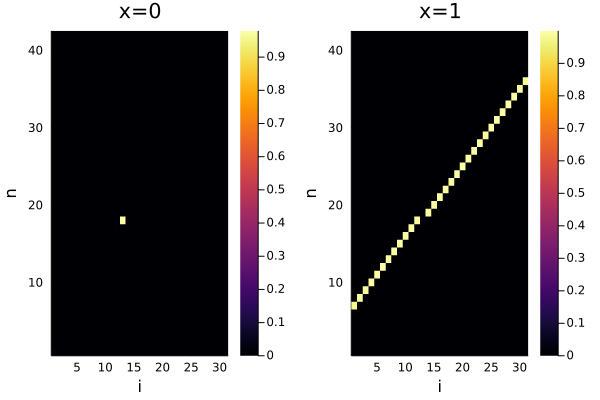

In [133]:
using Plots
#bel=Array(af.bpb.beliefs);
i=7
@show betas[i]
bel = bels_beta[i];
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1)

### diff last iterations

errs_beta[i] = 0.0009417533874511719


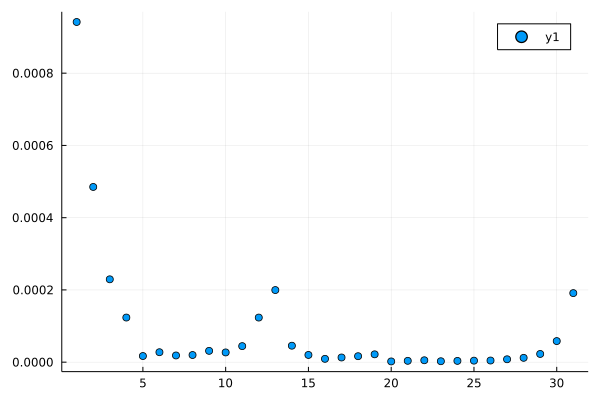

In [135]:
i=2
@show errs_beta[i]
scatter(1:L, [maximum(diff_beta[i][:,:,j]) for j=1:L])

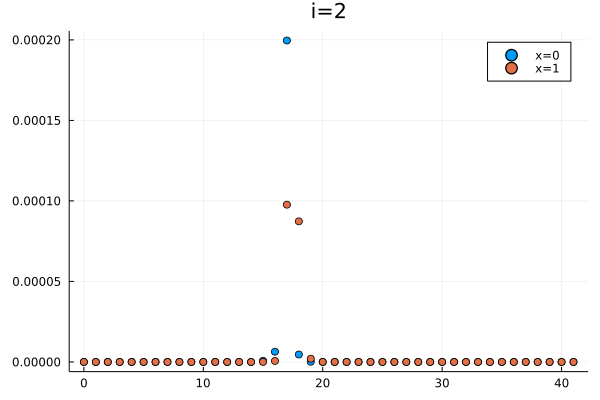

In [136]:
j=13
scatter(0:N+1, diff_beta[i][:,1,j], label="x=0", title="i=$i")
scatter!(0:N+1, diff_beta[i][:,2,j], label="x=1")

### diff between betas

In [156]:
i1 = 4; i2 = 5
maximum(abs.(bels_beta[i1] .- bels_beta[i2]))

0.026597201824188232

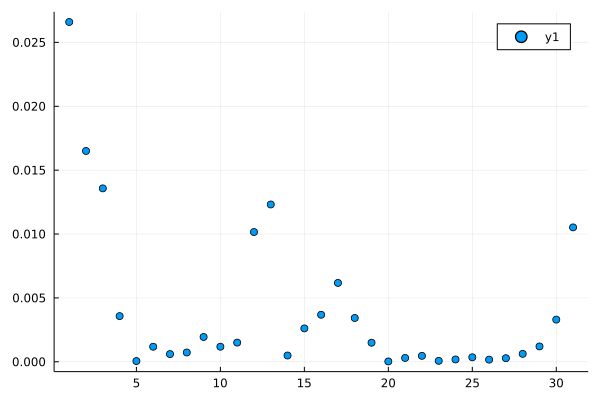

In [157]:
diftol = abs.(bels_beta[i1] .- bels_beta[i2])
scatter(1:L, [maximum(diftol[:,:,j]) for j=1:L])

j = 17


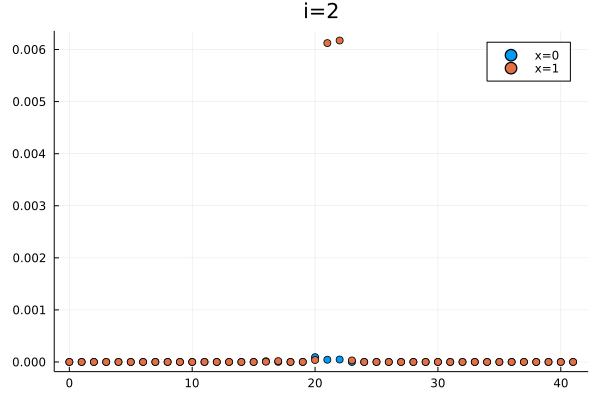

In [159]:
j=17
@show j
scatter(0:N+1, diftol[:,1,j], label="x=0", title="i=$i")
scatter!(0:N+1, diftol[:,2,j], label="x=1")

In [62]:
using OffsetArrays
P = fill(fill(0.0, 0:1,0:N+1), L)
for i=1:L
    P[i] = OffsetArray(transpose(af.bpb.beliefs[:,:,i]), 0:1,0:N+1)
end
BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L) == BpAlignGpu.decodeposterior(P, seq.strseq)

true

In [63]:
BpAlignGpu.check_assignment(P,true,N)

Let us check the assignment...
- 23 → (0, 0) 23-1 → (1, 95)
- 22 → (1, 95) 22-1 → (1, 108)
There are 2 short-range constraints not satisfied


false